# Application of a Pre-Trained Iterative Networks

Here, we are going to apply a pre-trained iterative neural network to a retrospectively undersampled cine MR image.

The network is given by the MODL approach [H.K. Aggarwal et al, IEEE TMI, 2018] and aternates between the following two steps:
$$ 
\mathbf{z}_k = u_{\Theta}(\mathbf{x}_k) \\
\mathbf{x}_{k+1} =  \underset{\mathbf{x}}{\arg \min} \, \frac{1}{2} \|\mathbf{F}_I \mathbf{x} - \mathbf{y}_I \|_2^2 + \frac{\lambda}{2} \|\mathbf{x}  - \mathbf{z}_k \|_2^2
$$
where $\mathbf{x}_0:=\mathbf{F}_I^H \mathbf{y}_I$. The minimizer of the above functional is given by:

$$
\mathbf{x}^\ast = \mathbf{F}^H (\mathbf{\Lambda} \mathbf{F}  \mathbf{z}_k + \frac{1}{1+\lambda} \mathbf{y}_I)
$$
with a diagonal operator  with diagonal entries $\mathbf{\Lambda}_{k,k}$
$$
\begin{cases}
\lambda/(1+\lambda) &\text { if } k\in I,\\
1 &\text{ if } k \not \in I.\\
\end{cases}
$$




In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tutorial1_data_driven_reg_methods.utils.helper_funcs import cine_cartesian_mask, cplx_torch2np, cplx_np2torch

from tutorial1_data_driven_reg_methods.networks.nets.unet import UNet
from tutorial1_data_driven_reg_methods.networks.nets.modl import MODL

First, we load the data. Since MR images are typicall complex-valued, we store them by reserving two channels for the real and the imaginary part. From this "ground-truth"-image, we retrospectively simulate the data-acquisiton process, by applying the FFT and setting a portion of the $k$-space coefficients to zero.

In [46]:
#load image and get image shape
xf = np.load('tutorial1_data_driven_reg_methods/toy_data/xf.npy')
im_shape = xf.shape

#convert to tensor
xf_tensor = cplx_np2torch(xf,0).unsqueeze(0).float()

#generate a mask with acceleration factor "acc_factor"
acc_factor = 4
mode = 'pytorch'
mask_tensor = cine_cartesian_mask(im_shape,acc_factor,mode='pytorch').float()

#apply FFT: N.B. the FFT is applied over the "signal_dim" penultimate
#dimensions starting from the penultimate. The last dimension is reserved
#for the real and imaginary parts of the image.
#thus, the k-space data will result in a tensor of shape (1,Nt,Nx,Ny,2)
normalized=True
kf_tensor = torch.fft(xf_tensor.permute(0, 4, 2, 3, 1), 2, normalized=normalized).float()

#apply binary mask and add noise
ku_tensor = mask_tensor.permute(0, 4, 2, 3, 1) * kf_tensor
ku_tensor+= torch.mean(ku_tensor)*torch.rand(ku_tensor.shape)

#reconstruct initial zero-filled reconstruction
xu_tensor = torch.ifft(ku_tensor, 2, normalized=normalized).permute(0, 4, 2, 3, 1)

Now, we define the network architecture. Then, we load some pre-trained weights.
Note that the network takes three inputs, namely the initial zero-filled reconstruction $\mathbf{x}_I$, the measured $k$-space data $\mathbf{y}_I$ and the binary mask $\mathbf{S}_I$.

For simplicity, all inputs should have the shape (mb, 2, Nx, Ny, Nt). This means that the $k$-space data's dimensions actually have to be permuted.

In [59]:
#define the hyper-parameter of the model
#thereby, U denotes the length of the network it
#was trained with, E the number of encoding stages of the U-Net, C the number of conv. layers 
#per stage and K the initial number of applied filters. CNN_type can either be "2D" or "3D" and specifies
#wheter 2D or 3D conv layers are used.
CNN_type = '2D'
U=8
E=1
C=4
K=64

#define the network architecture; MODL only defines the sequence of the operations,
#the type of CNN-block can be chosen to be eiterh a 2D or a 3D U-Net (for arbitrary E,C,K).
#If the model is loaded correctly, you should see <All keys matched successfully>
u = MODL(nu=U,
    n_enc_stages=E,
    n_convs_per_stage=C,
    n_filters=K,
    CNN_type = CNN_type,
    mode = 'testing')

#N.B: you can find the models in the folder below 
model_folder = 'tutorial1_data_driven_reg_methods/pre_trained_models/'
model_name = 'U{}E{}C{}K{}_{}.pt'.format(U,E,C,K,CNN_type)

#load the pre-trained weights
u.load_state_dict(torch.load( model_folder + model_name, map_location=torch.device('cpu')))

<All keys matched successfully>

The neural network contains not only the weights of the convolutional layer, but also one specific regularization parameter $\lambda$ which balances btween the strength of the data-fidelity and the regularization term.
Since $\lambda>0$, in the network, we allow $\lambda$ to be an arbitrary real number and use $\tilde{\lambda}:= \exp(\lambda)$ as the regularization parameter.

In [54]:
#print the value of log_lambda_reg
print(u.log_lambda_reg)
print(torch.exp(u.log_lambda_reg))

Parameter containing:
tensor(-6.3323, requires_grad=True)
tensor(0.0018, grad_fn=<ExpBackward>)


Now apply the CNN!

N.B. the use of "with torch.no_grad()" tells pytorch not to "register" the gradient-operations and thus requires less memory.

In [57]:
#FOR QUESTION 1.
#for varying lambda, we need to change it's value.
#Since it is stored as a trainable parameter in the architecture,
#we need to change the pytorch "state-dictionary"

#uncomment the following for changing the value.
state_dict = u.state_dict()
#state_dict['log_lambda_reg'] = torch.tensor(1e-2)
#u.load_state_dict(state_dict)

#print(u.log_lambda_reg)
#print(torch.exp(u.log_lambda_reg))

#apply the CNN
print('apply the CNN')
with torch.no_grad():
    #apply the CNN
    xcnn_tensor = u(xu_tensor, ku_tensor.permute(0,4,2,3,1), mask_tensor)

Parameter containing:
tensor(0.0100, requires_grad=True)
tensor(1.0101, grad_fn=<ExpBackward>)
apply the CNN
iteration 1 out of 8
iteration 2 out of 8
iteration 3 out of 8
iteration 4 out of 8
iteration 5 out of 8
iteration 6 out of 8
iteration 7 out of 8
iteration 8 out of 8


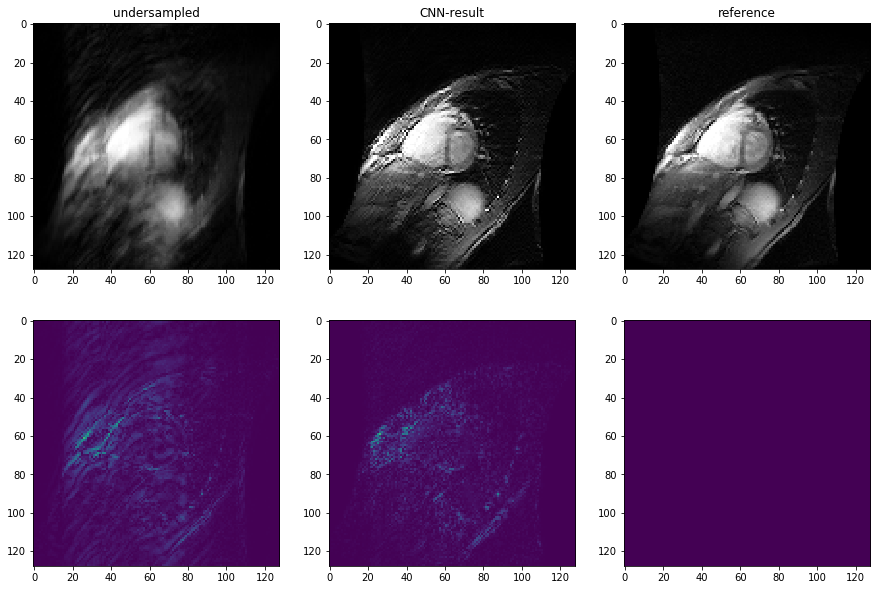

In [58]:
#convert to numpy array
xu = cplx_torch2np(xu_tensor.squeeze(0),0)
xcnn = cplx_torch2np(xcnn_tensor.detach().squeeze(0),0)

#show figure 
fig,ax = plt.subplots(2,3,figsize=(3*5,2*5))
arrs_list = [xu,  xcnn, xf]
errs_list = [arr - xf for arr in arrs_list]
names_list = ['undersampled', 'CNN-result', 'reference']

#choose time point and plot 
kt = 12
for kf in range(3):
    arr = arrs_list[kf]
    err = errs_list[kf]
    ax[0,kf].imshow(np.abs(arr)[...,kt],cmap=plt.cm.Greys_r,clim=[0,400])
    ax[1,kf].imshow(np.abs(err)[...,kt],cmap=plt.cm.viridis,clim=[0,400])
    ax[0,kf].set_title(names_list[kf])